In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay classification: cluster-splitting

## Current evaluation

### Pros
* can separate sequence and identify rudimentary clusters

### Cons
* can't distinguish stays from travels 
    * nothing created to do so.

## ToDos

* check that the newly split clusters are 
    * contain enough samples
    * have a total duration longer than the threshold
    * are not embedded within another cluster
* check that there are no embedded clusters
    * times don't overlap $\checkmark\to$ have function
    * if refined clusters are embedded, check if one cluster is noise
* check the stddev of the refined clusters are smaller


## Future directions

It may be best to use this as an initial pass for the box, or _any_, method, thereby confining the errors and speeding up the compute.

In [3]:
import numpy as np
import pandas as pd

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [5]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [7]:
shuffle(colors)

# Sythetic data

In [110]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.trajectory_class import get_rand_traj
from synthetic_data.plotting import plot_trajectory


event_frac = 0.01 #rand_range(1,0.01,0.001)[0]
duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

<Figure size 1440x720 with 0 Axes>

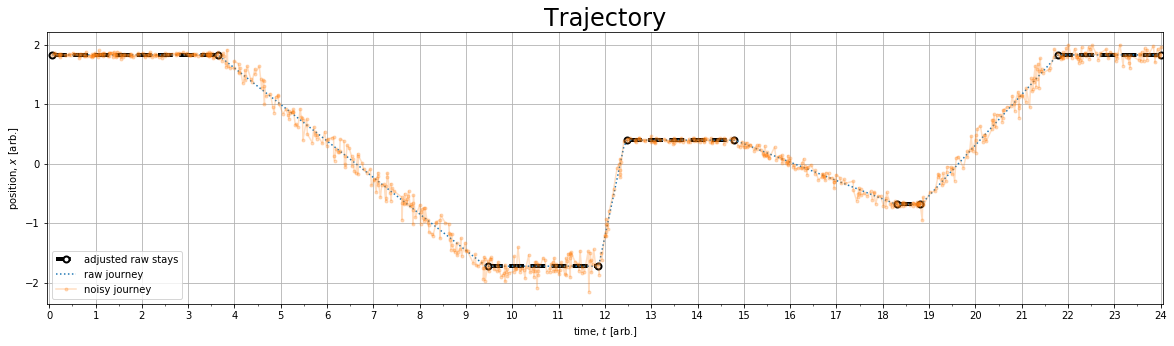

In [116]:
time_arr, raw_arr, noise_arr, segments = get_rand_traj(configs)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

plt.figure(figsize=(20,10))
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

# Clustering

## Split the clusters which have a temporal gap

In [102]:
time_thresh = 1/6
eps=0.25

In [103]:
clusters = list(range(time_arr.size))

In [104]:
from stay_classification.splitting_classifier.splitting_classifier import get_clusters

### Basic cluster identification

In [117]:
clusters = get_clusters(time_arr, noise_arr, eps, time_thresh)
len(clusters)

25

In [118]:
print("just the end-point indices:")
for clust in clusters:
    print(f"[{clust[0]},{clust[-1]}]")

just the end-point indices:
[0,168]
[170,185]
[191,205]
[219,229]
[231,245]
[251,254]
[280,291]
[299,308]
[310,321]
[324,336]
[338,343]
[349,376]
[395,435]
[438,447]
[467,574]
[576,612]
[614,635]
[637,691]
[694,699]
[701,714]
[716,720]
[728,734]
[736,748]
[778,783]
[785,859]


### Raw plotting

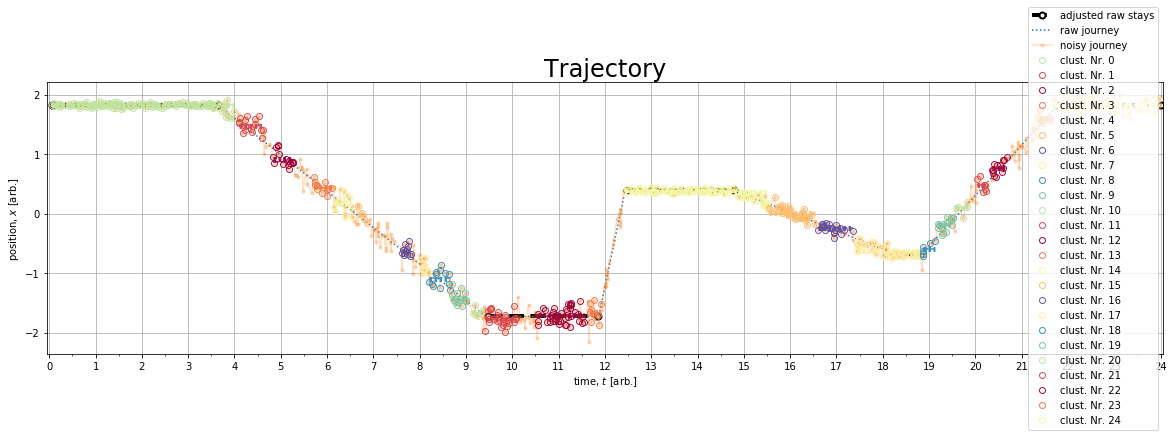

In [119]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

for cl_nr, clust in enumerate(clusters):
    
    color=colors[cl_nr%len(colors)]
    
    ax.plot(time_arr[clust], noise_arr[clust], 'o', color=color, alpha=0.95, markerfacecolor="None", label=f'clust. Nr. {cl_nr}')
    
    clust_med = np.median(noise_arr[clust])    
    ax.plot([time_arr[clust[0]],time_arr[clust[-1]]], [clust_med,clust_med], '--', color=color, alpha=0.95, label=None)
    
    clust_mean = np.mean(noise_arr[clust])    
    ax.plot([time_arr[clust[0]],time_arr[clust[-1]]], [clust_mean,clust_mean], '--', dashes=[0.5, 0.5], lw=5, color=color, alpha=0.95, label=None)
    
ax.legend(loc=7);

### IQR-plotting

In [120]:
box_plots = []
positions = []
widths = []
for cl_nr, clust in enumerate(clusters):
    
    color=colors[cl_nr%len(colors)]  
    
    # Get the subseqs
    xs = time_arr[clust]
    ys = noise_arr[clust]
    box_plots.append(ys)
    widths.append(xs[-1]-xs[0])
    positions.append((xs[-1]+xs[0])/2)

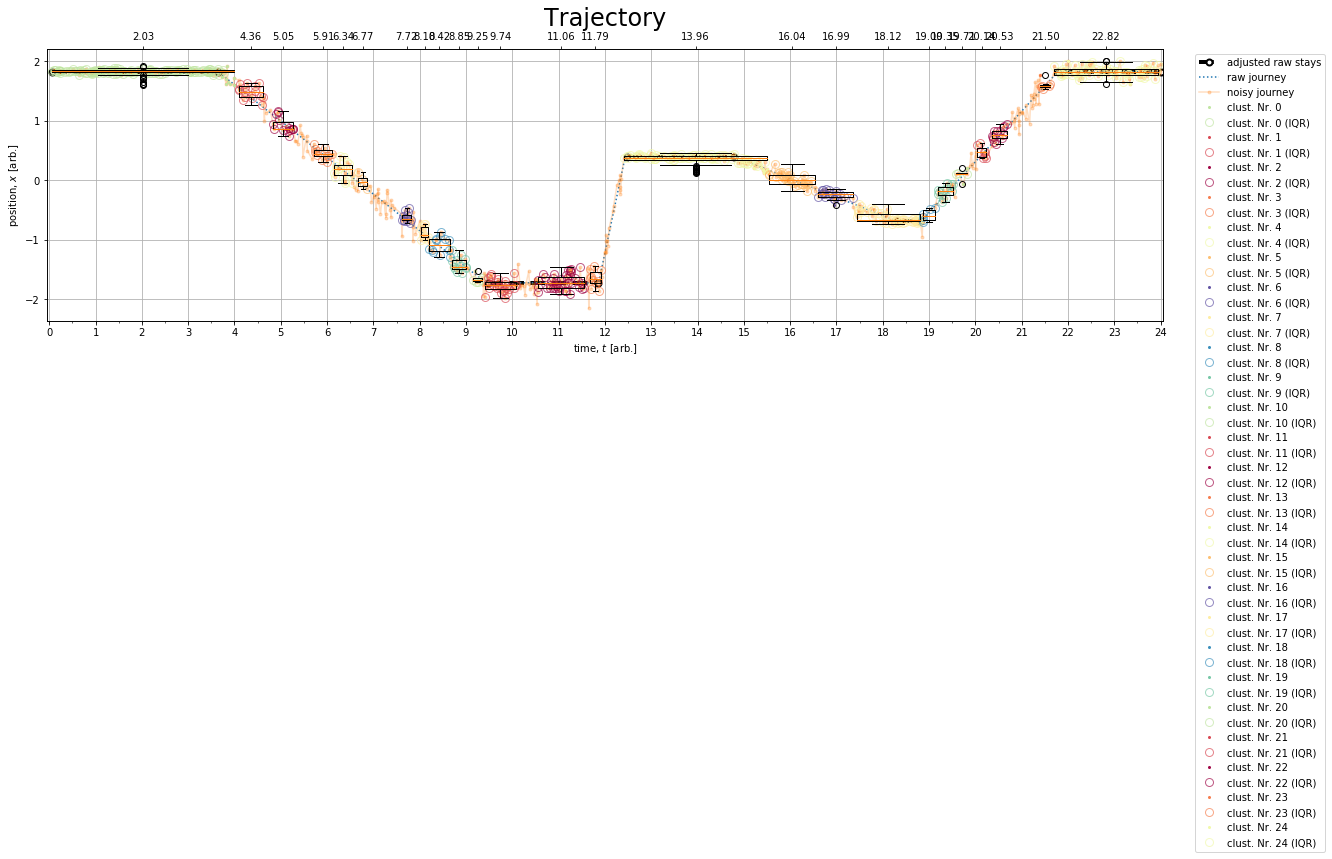

In [121]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);
for cl_nr, clust in enumerate(clusters):
    
    color=colors[cl_nr%len(colors)]  
    
    # Get the subseqs
    xs = time_arr[clust]
    ys = noise_arr[clust]

    # Mask to include only events within the IQR
    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')
    iqr = abs(q75 - q25)
    iqr_fact = 1.5
    
    # Apply the "without" mask
    mask=np.where((ys <= (q25 - iqr_fact * iqr)) | (ys >= (q75 + iqr_fact * iqr)))
    ax.plot(xs[mask], ys[mask], '.', alpha=0.95, color=color, markersize=4.0, label=f'clust. Nr. {cl_nr}')
    
    # Apply the "within" mask    
    mask=np.where((ys > (q25 - iqr_fact * iqr)) & (ys < (q75 + iqr_fact * iqr)))        
    ax.plot(xs[mask], ys[mask], 'o', color=color, markersize=8.0, alpha=0.65, markerfacecolor="None", label=f'clust. Nr. {cl_nr} (IQR)')

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(box_plots, labels=labels, positions=positions, widths=widths)      
axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [122]:
clusters = get_clusters(time_arr[::-1], noise_arr[::-1], eps, time_thresh)
len(clusters)

0